# hyperspectral-images: spectral unmixing & classification

> **Assignee** <br />
> full name: Antonopoulos Ilias <br />
> email: iantonopoulos@aueb.gr <br />
> ID: P3352004 <br />
> course: Machine Learning and Computational Statistics (M36104P) <br />
> program: MSc in Data Science (PT)

# Table of Contents

- [Reproducibility]()
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Spectral Unmixing](#Spectral-Unmixing)
 - [Least Squares with no constraints](#(a)-Least-Squares,-with-no-constraints)
 - [Least Squares with a sum-to-one constraint](#(b)-Least-Squares,-with-a-sum-to-one-constraint)
 - [Least Squares with a non-negativity constraint](#(c)-Least-Squares,-with-a-non-negativity-constraint)
 - [Least Squares with sum-to-one & non-negativity constraints](#(d)-Least-Squares,-with-sum-to-one-&-non-negativity-constraints)
 - [LASSO](#(e)-LASSO)
 - [Comparison and remarks]()
- [Classification](#Classification)
- [Combination]()

# Reproducibility

To easily reproduce the results of this Jupyter notebook, in a clean & efficient manner, do read the following:

Assuming that a [Python](https://www.python.org/) (v3.6.x or greater) is installed in your system:

- you could (optionally) upgrade `pip`:

```shell
python -m pip install --upgrade pip
```

- you could install all the necessary dependencies: 


**note**: the usage of a [virtual environment](https://docs.python.org/3/tutorial/venv.html#creating-virtual-environments) for this is highly advised, in order to keep your system-wide Python interpreter clean of unnecessary dependencies such as `scikit-learn` etc.

In [405]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.optimize
from sklearn import linear_model

## Exploratory Data Analysis

We'll begin by loading all the available data, trying to develop an initial understanding of the problem at hand.

In [406]:
salinas = sio.loadmat('data/Salinas_cube.mat')

salinas

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 14:46:31 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_cube': array([[[369, 579, 866, ...,  31,   9,  15],
         [369, 495, 735, ...,  33,  13,  15],
         [369, 495, 866, ...,  33,  11,  19],
         ...,
         [373, 398, 725, ...,  12,   4,   2],
         [373, 398, 659, ...,   8,   4,   0],
         [373, 482, 594, ...,   8,   0,   5]],
 
        [[441, 558, 787, ...,  26,  11,  16],
         [441, 558, 787, ...,  32,   7,  12],
         [441, 474, 787, ...,  26,   9,  16],
         ...,
         [447, 393, 590, ...,   3,   0,   9],
         [376, 393, 655, ...,  11,   0,   6],
         [376, 393, 590, ...,   3,   5,  -3]],
 
        [[444, 566, 790, ...,  30,  10,  15],
         [373, 566, 790, ...,  30,  12,  21],
         [373, 398, 790, ...,  32,  16,  13],
         ...,
         [305, 468, 534, ...,   6,   3,  -1],
         [376, 384, 664, ...,   6,   1,  -3],
         [376, 

In [407]:
hsi = salinas['salinas_cube']

hsi.shape

(220, 120, 204)

In [408]:
ends = sio.loadmat('data/Salinas_endmembers.mat')

ends

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 23 15:44:08 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_endmembers': array([[392.98079561, 388.55390904, 325.42702051, ..., 446.79332153,
         345.42833194, 306.5428824 ],
        [496.35070873, 504.777721  , 418.4185766 , ..., 585.49152542,
         430.39340598, 398.5928382 ],
        [702.8079561 , 735.25140521, 630.0747889 , ..., 838.19251202,
         574.78066499, 566.7683466 ],
        ...,
        [  4.96799268,  48.75217169,  28.2907117 , ...,  31.76979509,
           4.73959206,  15.29619805],
        [  1.9304984 ,  17.03628002,   9.76839566, ...,  11.04528206,
           1.76809165,   5.29045093],
        [  2.83539095,  27.07307103,  15.36670688, ...,  17.61801164,
           2.63593182,   8.59195402]])}

In [409]:
endmembers = ends['salinas_endmembers']

endmembers.shape

(204, 7)

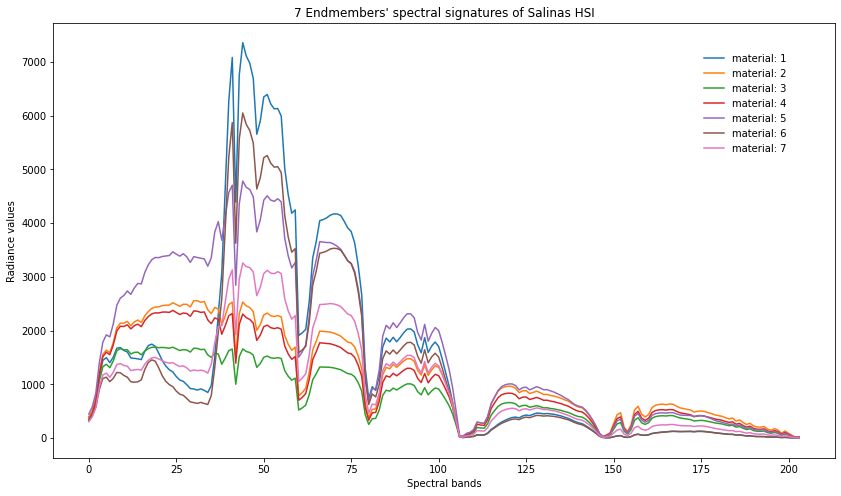

In [410]:
fig = plt.figure(figsize=(14, 8))

plt.plot(endmembers)
plt.legend(['material: {}'.format(i + 1) for i in range(7)], bbox_to_anchor=(0.95, 0.95), framealpha=0)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title("7 Endmembers' spectral signatures of Salinas HSI")

plt.show()

In [411]:
ground_truth = sio.loadmat('data/Salinas_gt.mat')

ground_truth

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 23:21:46 2021',
 '__version__': '1.0',
 '__globals__': [],
 'salinas_gt': array([[0, 0, 0, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        [6, 6, 6, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [412]:
labels = ground_truth['salinas_gt']

labels.shape

(220, 120)

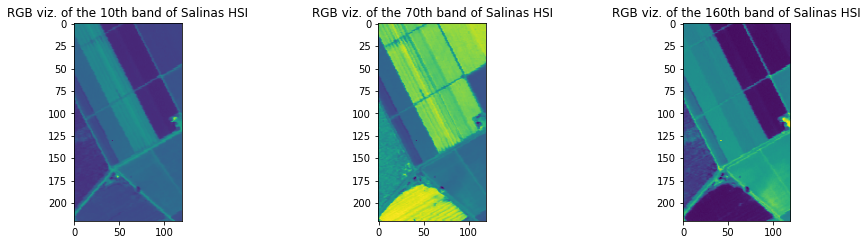

In [413]:
fig = plt.figure(figsize=(20, 8))

ax = fig.add_subplot(2,2,1)

ax.imshow(hsi[:, :, 10])
ax.set_title('RGB viz. of the 10th band of Salinas HSI')

ax = fig.add_subplot(2,3,2)

ax.imshow(hsi[:, :, 70])
ax.set_title('RGB viz. of the 70th band of Salinas HSI')

ax = fig.add_subplot(2,2,2)

ax.imshow(hsi[:, :, 160])
ax.set_title('RGB viz. of the 160th band of Salinas HSI')

plt.show()

We can definitely see an area with landfields, a partial road network etc.

According to the dataset, it is an area of the [Salinas valley](https://en.wikipedia.org/wiki/Salinas_Valley) in California, USA.

In [414]:
salinas_labels = sio.loadmat('data/classification_labels_Salinas.mat')

salinas_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Mar  1 16:49:08 2021',
 '__version__': '1.0',
 '__globals__': [],
 'operational_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'test_set': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=uint8),
 'training_set': array([[0],
        [6],
        [6],
        ...,
        [0],
        [0],
        [0]], dtype=uint8)}

In [415]:
training_set = (np.reshape(salinas_labels['training_set'], (120, 220))).T
test_set = (np.reshape(salinas_labels['test_set'], (120, 220))).T
operational_set = (np.reshape(salinas_labels['operational_set'], (120, 220))).T

In [416]:
training_set.shape

(220, 120)

In [417]:
test_set.shape

(220, 120)

In [418]:
operational_set.shape

(220, 120)

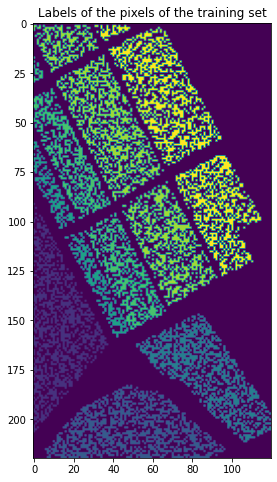

In [419]:
fig = plt.figure(figsize=(14, 8))

plt.imshow(training_set)
plt.title('Labels of the pixels of the training set')

plt.show()

# Spectral Unmixing

In this first part, our aim is to perform spectral unmixing on each one of the pixels in the image with
nonzero label, with respect to the $m = 7$ endmembers.

We adopt the **linear spectral unmixing hypothesis**:

$$ y = X \theta + \eta $$

where:

- $y$ is the $L$-dimensional spectral signature of the pixel under study
- $X$ is composed by the spectral signatures $x_1, \dots, x_m$ of the pure pixels (i.e. pure materials) in the image - they are also $L$-dimensional columns
- $\theta$ is the $m$-dimensional abundance vector of the pixel
- $\eta$ is the $L$-dimensional i.i.d., zero-mean Gaussian noise vector

We also define the reconstruction error as follows:

$$ \cfrac{1}{N} \sum_{n=1}^N \lVert y_i - X \theta_i \rVert^2 $$

**note**: in our particular problem, $N$ designates the total number of pixels in the image with non-zero label.

In [420]:
xi, yi = np.nonzero(labels)

nonzero_hsi = hsi[xi, yi, :]

nonzero_hsi.shape

(16929, 204)

### (a) Least Squares, with no constraints

We will firstly approach this task via the unconstrained Least Squares method.

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2 $$

It can be shown that: $$ \hat{\theta} = (X^TX)^{-1} X^Ty$$

In [421]:
def unconstrained_least_squares_solver(image_cube, endmembers):
    """Implements a Least Squares solver, assuming no constraints.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    inverse = np.linalg.inv(np.dot(endmembers.T, endmembers))
    
    return inverse.dot(endmembers.T).dot(image_cube.T)

In [422]:
def abundance_maps(estimates, xi, yi):
    """Plots the abundance maps for the 7 materials.
    
    Args:
        estimates: an (7, x) array, containing the unmixing estimates.
        xi: a (x,) array with the non-zero x positions of pixels.
        yi: a (y,) array with the non-zero y positions of pixels

    Returns:
        The abundance maps.
    """
    fig, axs = plt.subplots(3, 3, figsize=(20, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    abundance_maps = np.zeros((225, 130, 9))
    
    for i in range(7):

        abundance_maps[xi, yi, i] = estimates[i, :]

        axs[i].imshow(abundance_maps[:, :, i])
        axs[i].set_title('material: {}'.format(i + 1))
        axs[i].grid(False)

    fig.tight_layout()
    
    # remove 8th and 9th subplot entry of the 3x3 grid
    fig.delaxes(axs[-1])
    fig.delaxes(axs[-2])

In [423]:
def reconstruction_error(image_cube, endmembers, labels, estimates):
    """Implements the reconstruction error metric.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
        estimates: an (7, x) array, containing the unmixing estimates.
    
    Returns (float):
        The reconstruction error.
    """
    n = np.count_nonzero(labels)
    
    return np.linalg.norm(image_cube.T - np.dot(endmembers, estimates)) ** 2 / n

Let's proceed with the calculations:

In [424]:
estimation = unconstrained_least_squares_solver(nonzero_hsi, endmembers)

estimation.shape

(7, 16929)

In [425]:
error1 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation)

print('method: unconstrained Least Squares')
print(f'reconstruction error: {error1}\n')

method: unconstrained Least Squares
reconstruction error: 35058.88066277267



abundance map per endmember/material:


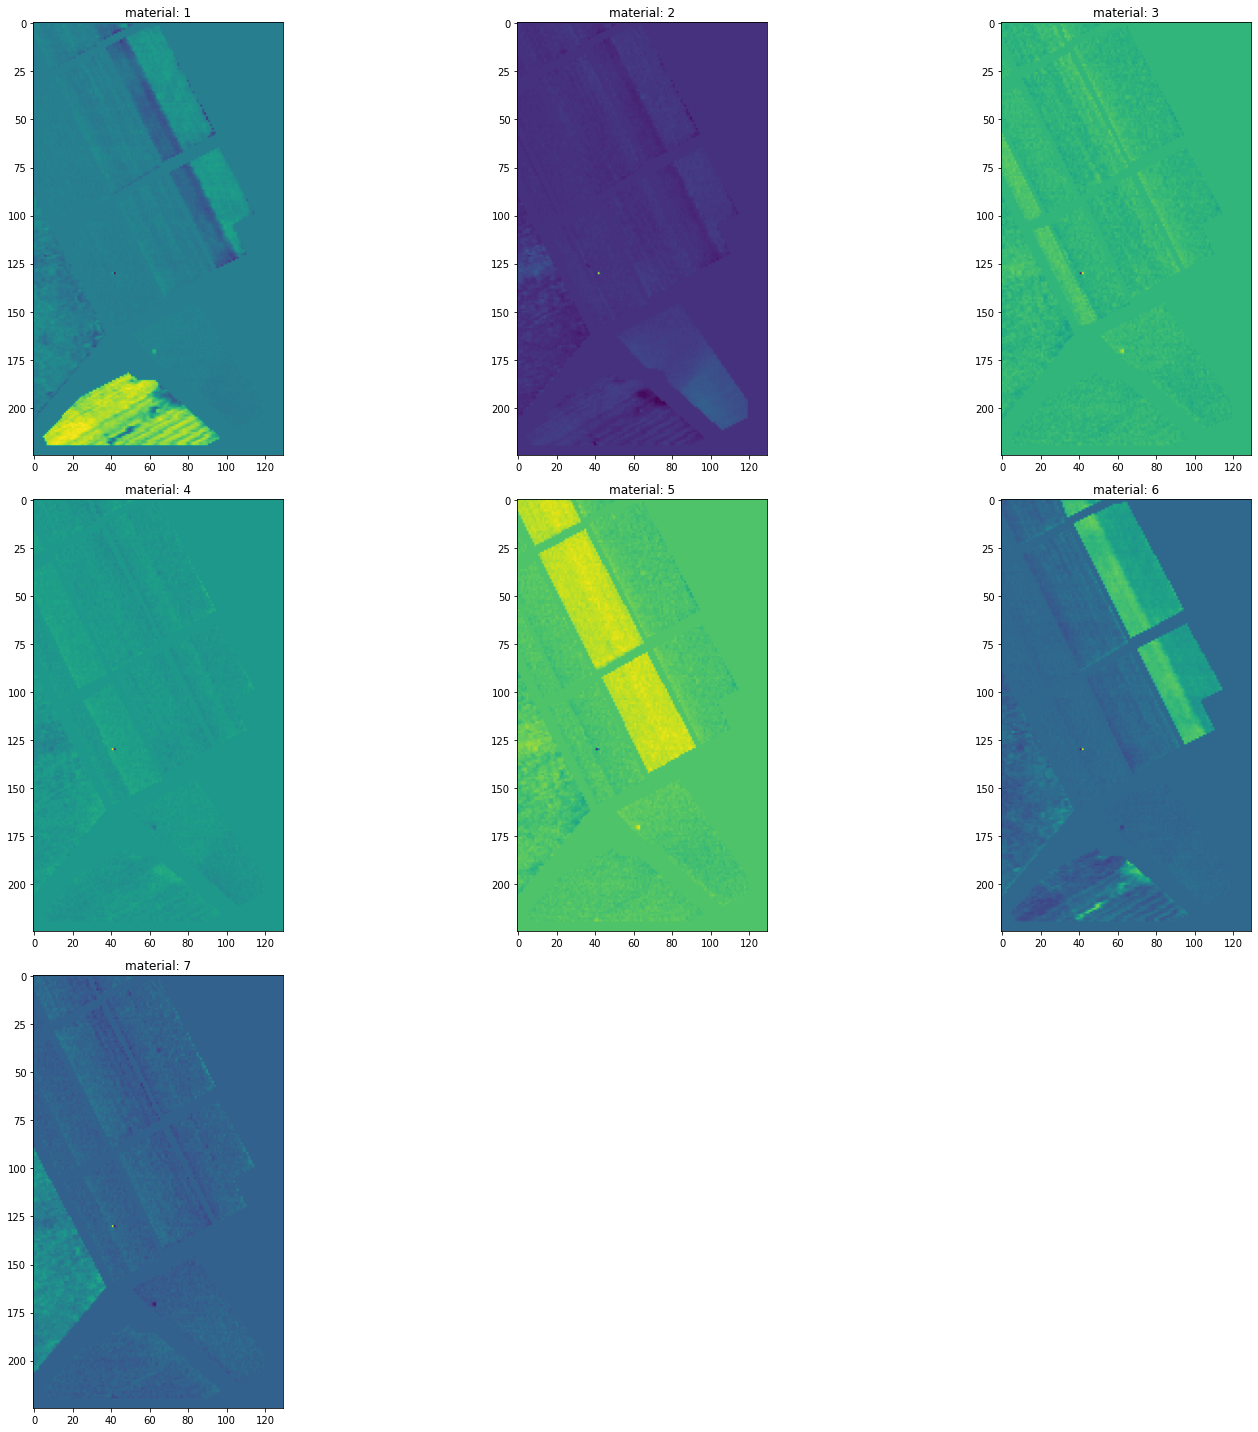

In [426]:
print('abundance map per endmember/material:')

abundance_maps(estimation, xi, yi)

In [427]:
def visualize_estimates(estimates):
    """Visualizes the estimates across materials.
    
    Args:
        estimates: an (7, x) array, containing the unmixing estimates.
    
    Returns:
        The visualization.
    """
    fig = plt.figure(figsize=(14, 8))
    
    ax = fig.add_subplot(111)
    
    ax.hist(np.sum(estimation, axis=0),
            density=True, 
            bins=30)
    
    ax.set_title('$\sum_1^7 \\theta_i$')

    plt.show()

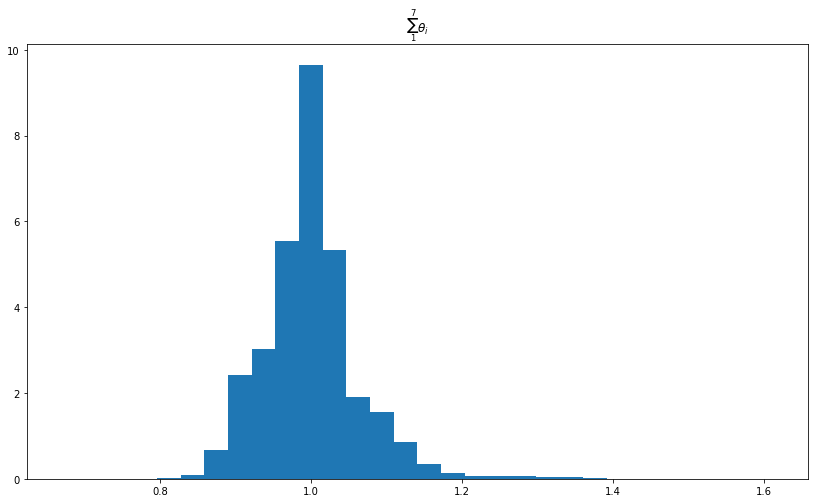

In [428]:
visualize_estimates(estimation)

### (b) Least Squares, with a sum-to-one constraint

We will now include a sum-to-one constraint to our Least Squares problem:

That is, we will solve the problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \sum_{i=1}^7 \theta_i = 1$$

There are a couple of ways to subject the problem to the sum-to-one constraint. Namely:
- solve the unconstrained problem and perform suitable post-transformation to recover the under-constraint solution 
- introduce constraint as an extra problem equation, along with a weighting policy in favor of this equation, so as to "force" solution to uphold constraint.
- etc.

We will utilize the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

In [429]:
def sum_to_one_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, assuming the sum-to-one constraint.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    # define objective function
    def obj_func(x, a, b):
        return np.linalg.norm(a.dot(x) - b) ** 2
    
    # define constraint(s)
    constraints = {'type': 'eq', 'fun': lambda y: np.sum(y) - 1}  
    
    # define minimization strategy
    def minimizer(c):
        
        inits = np.zeros((1, 7))
        
        for i in range(c):
            
            res = scipy.optimize.minimize(
                obj_func, 
                inits, 
                args=(endmembers, image_cube[i, :]),
                method='SLSQP',
                tol='1e-6',
                constraints=constraints,
            )
            
            yield res.x
    
    n = np.count_nonzero(labels)
    
    return np.array([*minimizer(n)]).T

In [430]:
estimation = sum_to_one_squares_solver(nonzero_hsi, endmembers, labels)

estimation.shape

(7, 16929)

In [431]:
error2 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation)

print('method: Least Squares with sum-to-one constraint')
print(f'reconstruction error: {error2}\n')

method: Least Squares with sum-to-one constraint
reconstruction error: 43082.576302782494



abundance map per endmember/material:


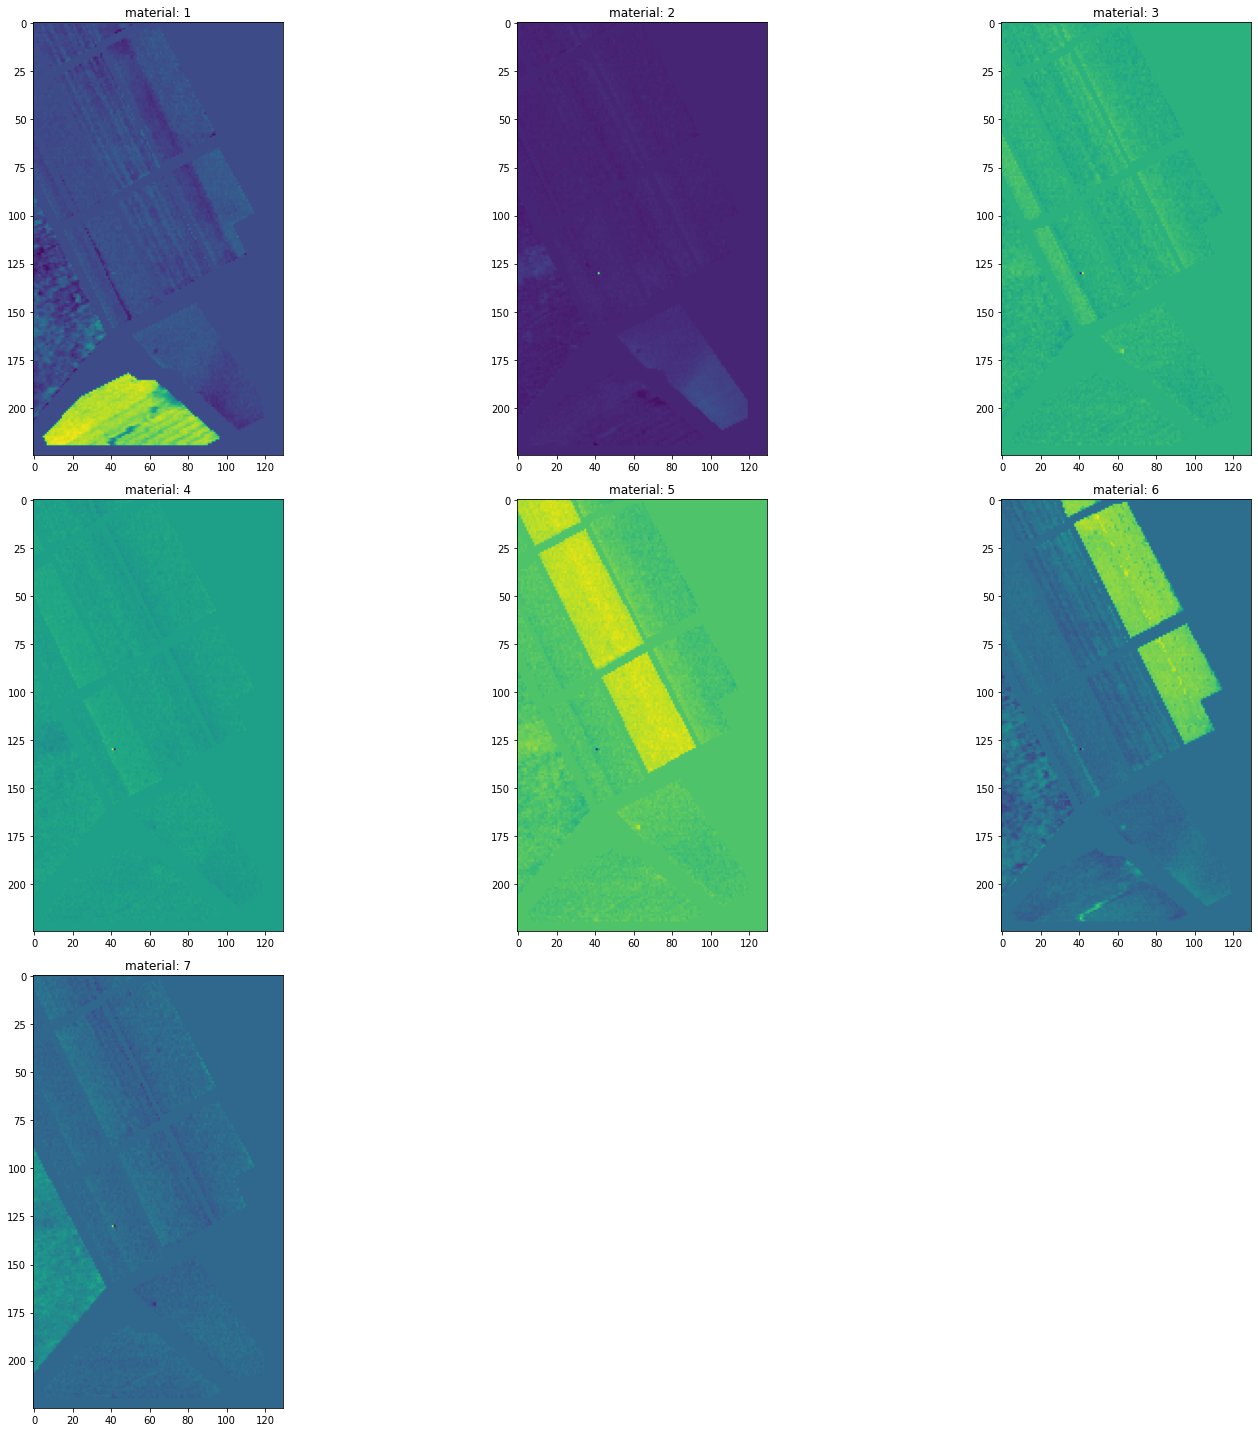

In [432]:
print('abundance map per endmember/material:')

abundance_maps(estimation, xi, yi)

In [433]:
np.sum(estimation, axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

In [434]:
np.sum(np.sum(estimation, axis=0))

16929.0

The estimated params indeed respect the sum-to-one constraint.

In [435]:
# TODO: add also my WLS approach.

### (c) Least Squares, with a non-negativity constraint

We will now attempt to solve the LS problem, by introducing a non-negativity constraint:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 $$

A key observation here is that we cannot use a direct approach as in **(a)** but rather an iterative algorithm is required.

Since this is a straightforward restriction (enforcing bounds on the values a parameter can get) we will utilize the respective open-source implementation: [scipy.optimize.nnls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html)

In [436]:
def nonnegative_least_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, assuming the non-negativity constraint.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    def optimizer(c):
        
        for i in range(c):
            
            theta, _ = scipy.optimize.nnls(endmembers, image_cube[i, :])
            
            yield theta
            
    n = np.count_nonzero(labels)
    
    return np.array([*optimizer(n)]).T

In [437]:
estimation = nonnegative_least_squares_solver(nonzero_hsi, endmembers, labels)

estimation.shape

(7, 16929)

In [438]:
error3 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation)

print('method: Least Squares with non-negativity constraint')
print(f'reconstruction error: {error3}\n')

method: Least Squares with non-negativity constraint
reconstruction error: 156104.18220644674



abundance map per endmember/material:


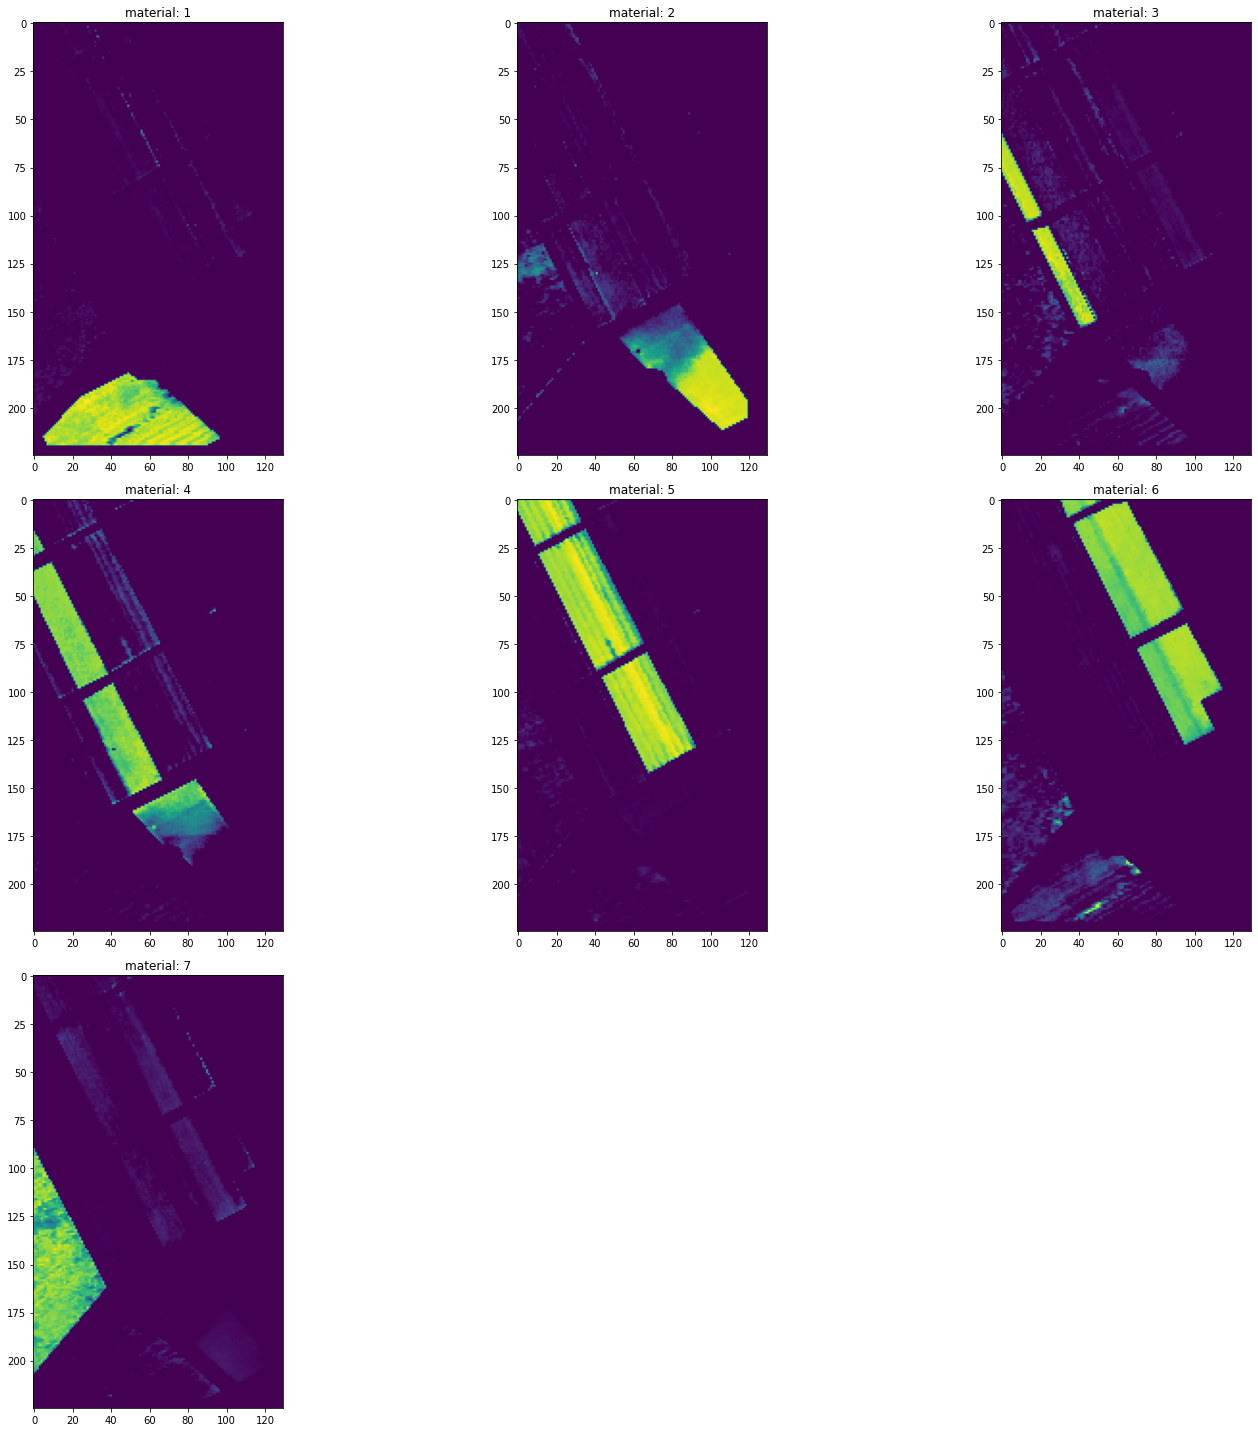

In [439]:
print('abundance map per endmember/material:')

abundance_maps(estimation, xi, yi)

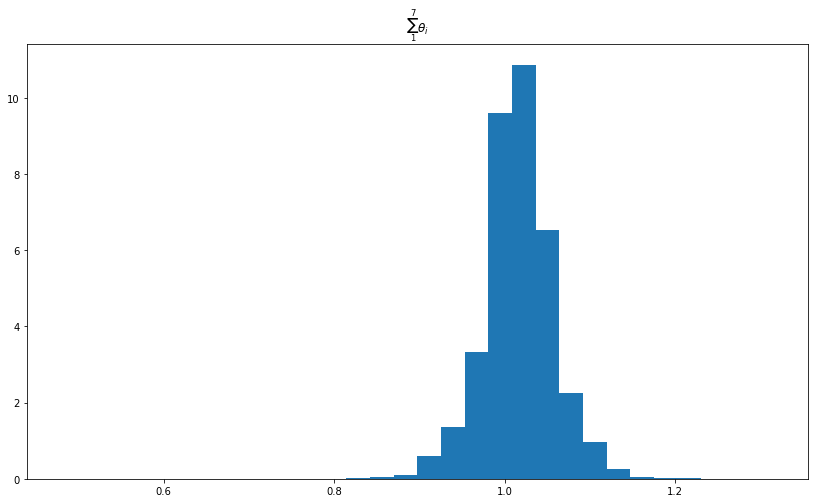

In [440]:
visualize_estimates(estimation)

### (d) Least Squares, with sum-to-one & non-negativity constraints

We will now combine the previous two, by introducing a non-negativity constraint as well as a sum-to-one constraint:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \theta \geq 0 \phantom{o}\text{and}\phantom{o}  \sum_{i=1}^7 \theta_i = 1$$

Again, an iterative algorithm is required to solve the problem. We will again go with [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function.

Before going into the implementation details, it is worth noting that something like:

$$\theta = [1/7, \dots, 1/7]^T$$

is a reasonable parameter configuration, since both constraints need to be upheld.

Let's see how it plays out in practice.

In [441]:
def nn_and_sum_to_one_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, assuming the sum-to-one and non-negativity constraints.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    # define objective function
    def obj_func(x, a, b):
        return np.linalg.norm(a.dot(x) - b) ** 2
    
    # define constraint(s)
    constraints = {'type': 'eq', 'fun': lambda y: np.sum(y) - 1}  
    bounds = [[0, None]] * endmembers.shape[1]
    
    # define minimization strategy
    def minimizer(c):
        
        inits = np.zeros((1, 7))
        
        for i in range(c):
            
            res = scipy.optimize.minimize(
                obj_func, 
                inits, 
                args=(endmembers, image_cube[i, :]),
                bounds=bounds,
                method='SLSQP',
                tol='1e-6',
                constraints=constraints,
            )
            
            yield res.x
    
    n = np.count_nonzero(labels)
    
    return np.array([*minimizer(n)]).T

In [442]:
estimation = nn_and_sum_to_one_squares_solver(nonzero_hsi, endmembers, labels)

estimation.shape

(7, 16929)

In [443]:
error4 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation)

print('method: Least Squares with sum-to-one + non-negativity constraints')
print(f'reconstruction error: {error4}\n')

method: Least Squares with sum-to-one + non-negativity constraints
reconstruction error: 339088712.2633131



abundance map per endmember/material:


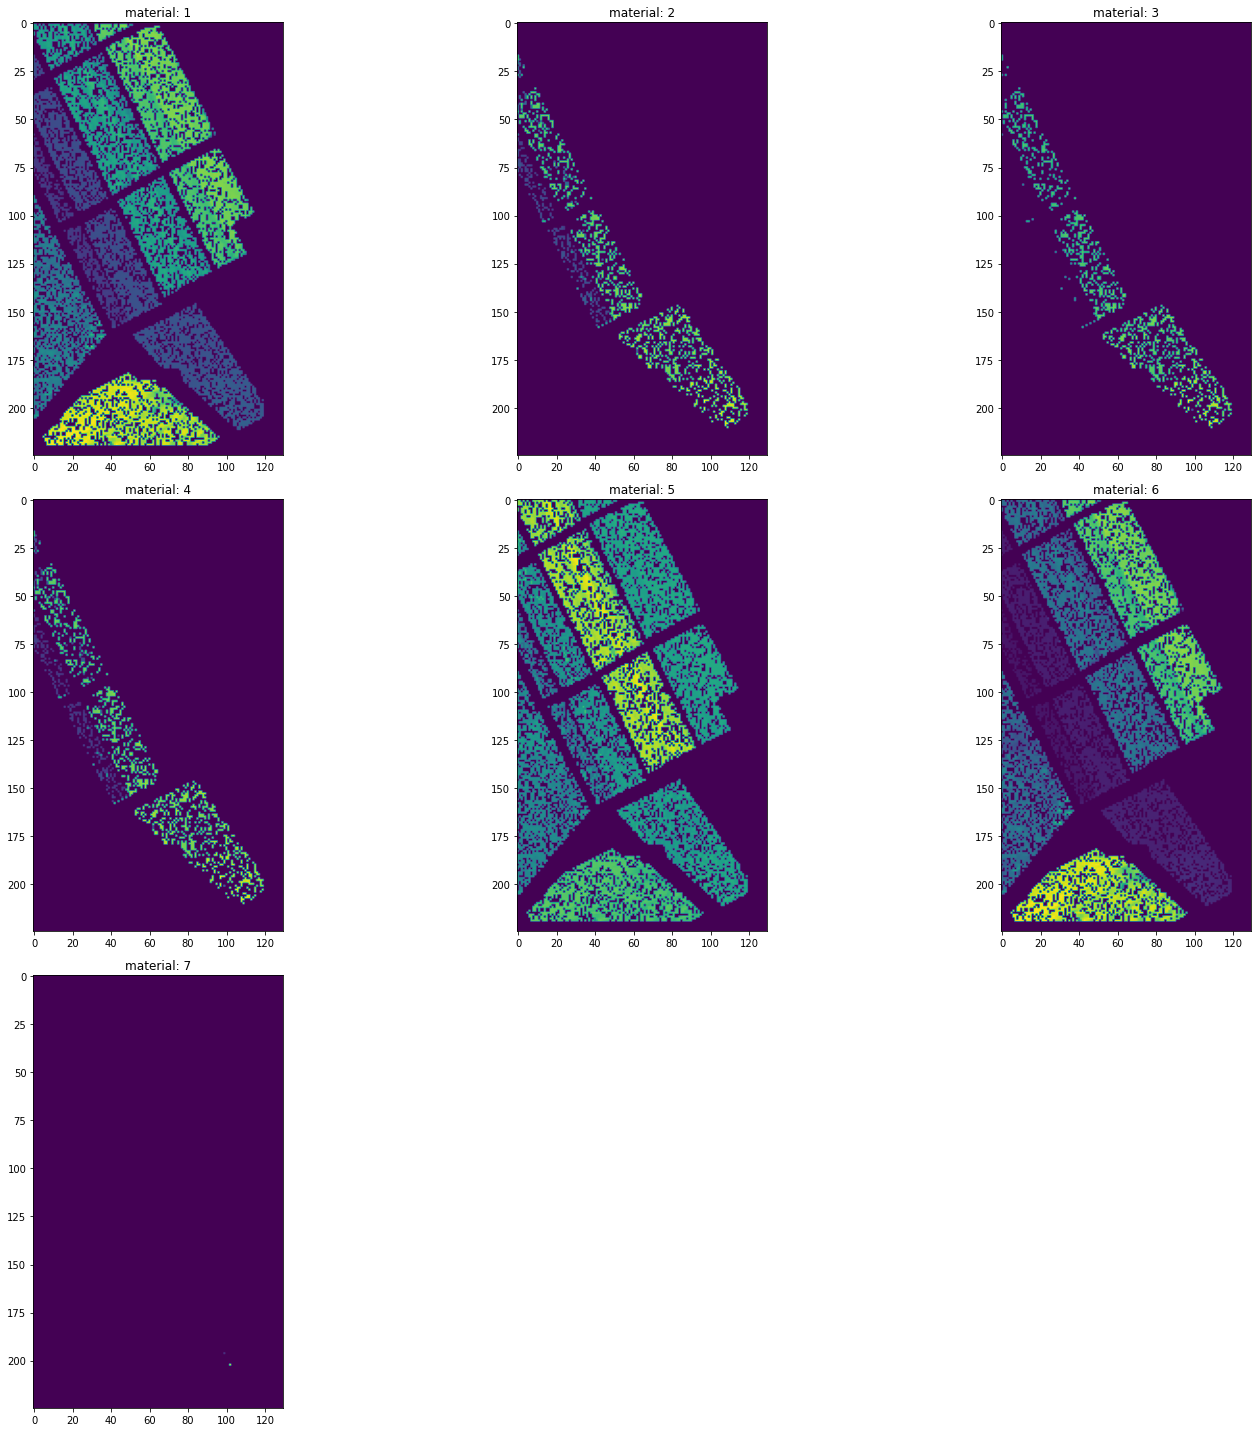

In [444]:
print('abundance map per endmember/material:')

abundance_maps(estimation, xi, yi)

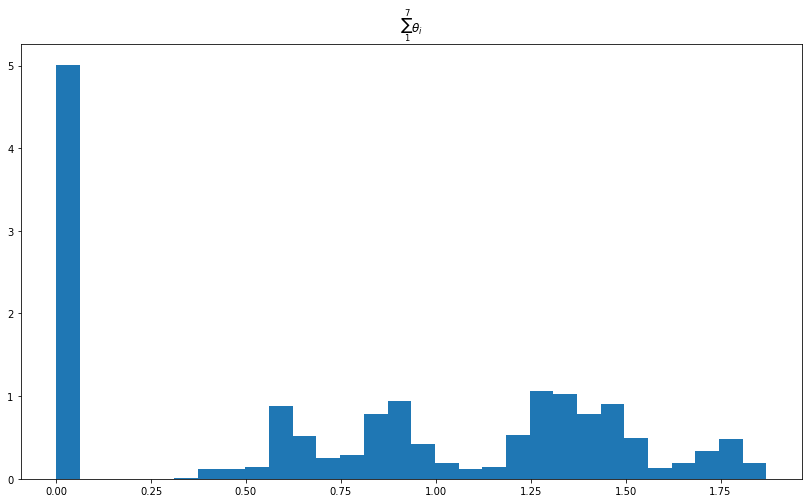

In [445]:
visualize_estimates(estimation)

### (e) LASSO

We would now try to impose a sparsity on $\theta$, via LASSO and $L_1$ norm minimization.

That is, we would like to solve the following regularized Least Squares problem:

$$ \text{argmin}_{\theta} J(\theta), \phantom{o} \text{where} \phantom{o} J(\theta) = \lVert y - X \theta \rVert^2, \phantom{o} \text{subject to} \phantom{o} \lVert \theta \rVert_1 \leq \rho $$

We will utilize the [scikit-learn-provided](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) LASSO i.e. a linear model trained with $L_1$ prior as regularizer.

A low reconstruction error can be yielded by a Lagrangian of `37`.

In [446]:
def lasso_least_squares_solver(image_cube, endmembers, labels):
    """Implements a Least Squares solver, with a LASSO regularization scheme.
    
    Args:
        image_cube: an (x, l) array, that contains non-zero pixels.
        endmembers: an (l, 7) array.
        labels: an (m, n) array.
    
    Returns:
        The Least Squares solution, as an (7, x) array, containing the unmixing estimates.
    """
    clf = linear_model.Lasso(alpha=37, positive=True, fit_intercept=False, max_iter=1e7)
    
    def optimizer(c):
        
        for i in range(c):
            
            clf.fit(endmembers, nonzero_hsi[i, :])
            
            yield clf.coef_
    
    n = np.count_nonzero(labels)
    
    return np.array([*optimizer(n)]).T

In [447]:
estimation = lasso_least_squares_solver(nonzero_hsi, endmembers, labels)

estimation.shape

(7, 16929)

In [448]:
error5 = reconstruction_error(nonzero_hsi, endmembers, labels, estimation)

print('method: LASSO')
print(f'reconstruction error: {error5}\n')

method: LASSO
reconstruction error: 158097.38670329918



abundance map per endmember/material:


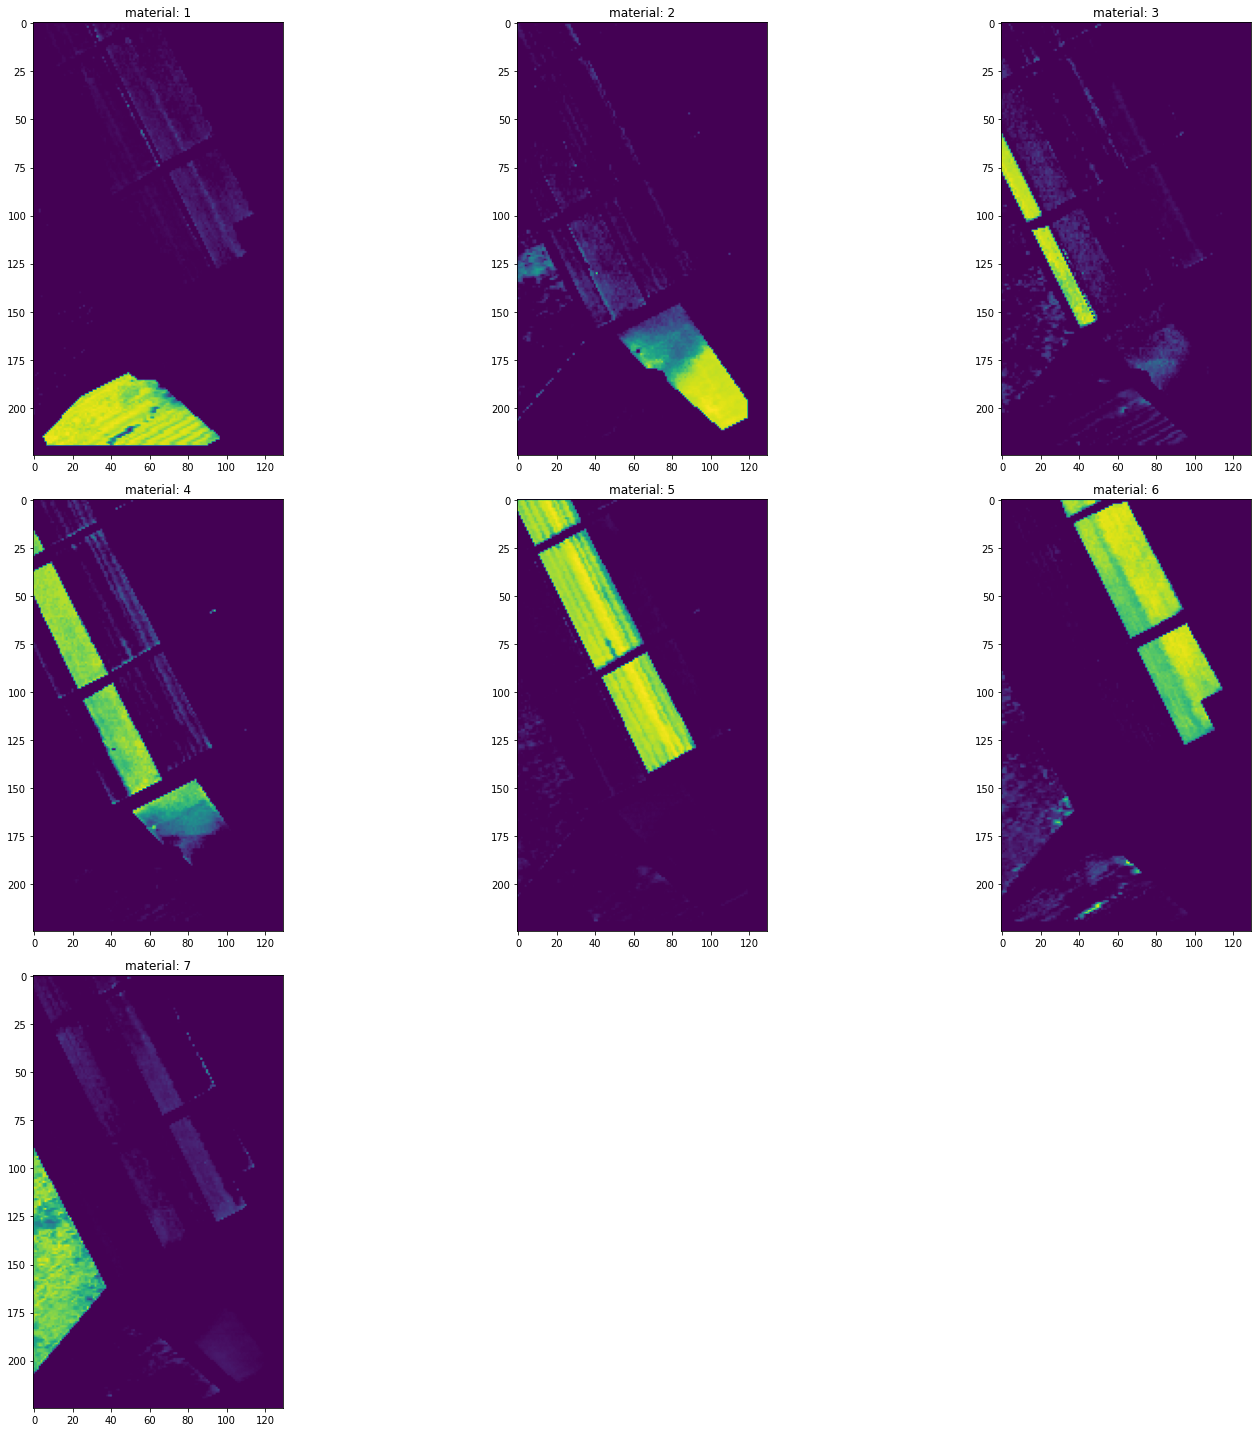

In [449]:
print('abundance map per endmember/material:')

abundance_maps(estimation, xi, yi)

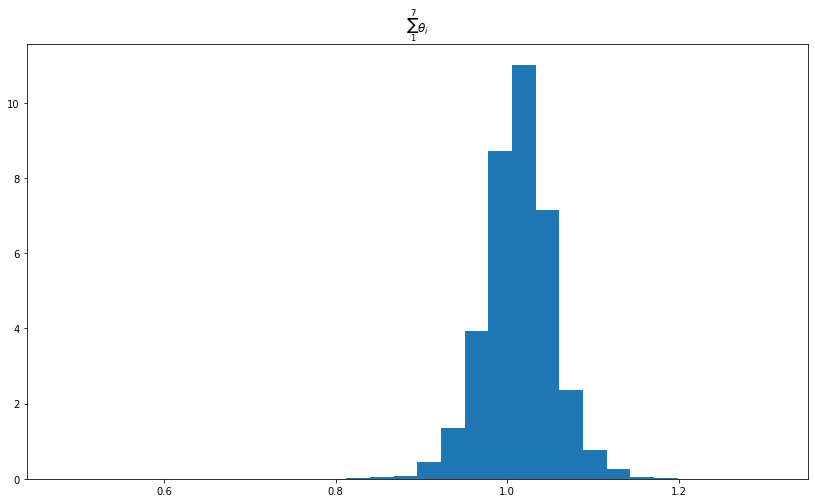

In [450]:
visualize_estimates(estimation)

### Comparison and Remarks

In [451]:
# TODO: write remarks about the comparison

In [452]:
errors = [error1, error2, error3, error4, error5]

errors

[35058.88066277267,
 43082.576302782494,
 156104.18220644674,
 339088712.2633131,
 158097.38670329918]

In [453]:
method_names = ['Unconstrained LS', 'sum-to-one LS', 'nn LS', 'sum-to-one + nn LS', 'LASSO']

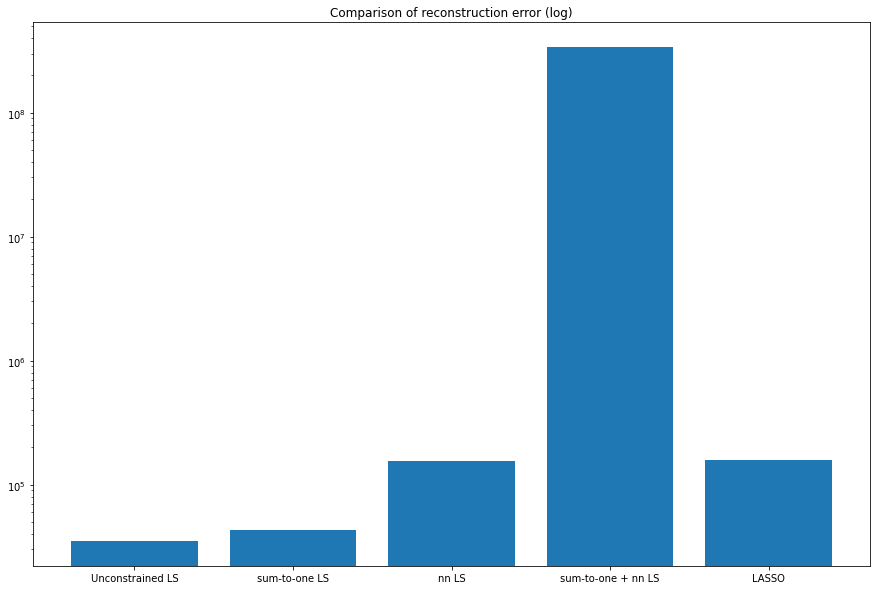

In [454]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(111)

ax.set_title('Comparison of reconstruction error (log)')

ax.bar(method_names, errors, align='center')
ax.set_yscale('log')

plt.show()

# Classification

In [455]:
# TODO

# Combination

In [456]:
# TODO